In [2]:
import os

import pandas as pd
import numpy as np
import seaborn as sns 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder


from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [3]:
# Helper Functions
def list_feature_values(df):
    '''Function will return Dataframe with Fearure Descriptions: '''
    _ = pd.DataFrame(columns = ['Cardinality', 'Values'])
    for col in df.columns:
        FeatureName = col
        Feature_Cardinality = df[col].nunique()
        Feature_Cardinality_Values = [
            ", ".join(list(map(str, df[col].unique())))
            if df[col].nunique() < 10 
            else f'''{", ".join(list(map(str, df[col].unique()[:10])))}, ...'''
        ]
        _index = _.shape[0]
        _.loc[FeatureName, "Cardinality"] = Feature_Cardinality
        _.loc[FeatureName, "Values"] = Feature_Cardinality_Values
        _.loc[FeatureName, 'Null Values'] = round(100*(df[col].isna().sum()/df.shape[0]), 2)
    return _

In [4]:
df = pd.read_parquet(r'../dataset/churn.parquet')
df.head(3)

,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,18,F,XW0DQ7H,Village,Platinum Membership,17-08-2017,No,xxxxxxxx,Gift Vouchers/Coupons,?,...,300.63,53005.25,17,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,0
1,32,F,5K0N3X1,City,Premium Membership,28-08-2017,?,CID21329,Gift Vouchers/Coupons,Desktop,...,306.34,12838.38,10,NaN,Yes,No,Yes,Solved,Quality Customer Care,0
2,44,F,1F2TCL3,Town,No Membership,11-11-2016,Yes,CID12313,Gift Vouchers/Coupons,Desktop,...,516.16,21027.00,22,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,1


In [5]:
print('count: Records:', df.shape[0])
print('count: features:', df.shape[1], end = '\n\n')


count: Records: 36992
count: features: 23



In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           36992 non-null  int64  
 1   gender                        36992 non-null  object 
 2   security_no                   36992 non-null  object 
 3   region_category               31564 non-null  object 
 4   membership_category           36992 non-null  object 
 5   joining_date                  36992 non-null  object 
 6   joined_through_referral       36992 non-null  object 
 7   referral_id                   36992 non-null  object 
 8   preferred_offer_types         36704 non-null  object 
 9   medium_of_operation           36992 non-null  object 
 10  internet_option               36992 non-null  object 
 11  last_visit_time               36992 non-null  object 
 12  days_since_last_login         36992 non-null  int64  
 13  a

In [7]:
# Checking NA Values
round(100*((df.isna() | df.isnull()).sum()/df.shape[0]), 2)

age                              0.00
gender                           0.00
security_no                      0.00
region_category                 14.67
membership_category              0.00
joining_date                     0.00
joined_through_referral          0.00
referral_id                      0.00
preferred_offer_types            0.78
medium_of_operation              0.00
internet_option                  0.00
last_visit_time                  0.00
days_since_last_login            0.00
avg_time_spent                   0.00
avg_transaction_value            0.00
avg_frequency_login_days         0.00
points_in_wallet                 9.31
used_special_discount            0.00
offer_application_preference     0.00
past_complaint                   0.00
complaint_status                 0.00
feedback                         0.00
churn_risk_score                 0.00
dtype: float64

<Figure size 1200x800 with 0 Axes>

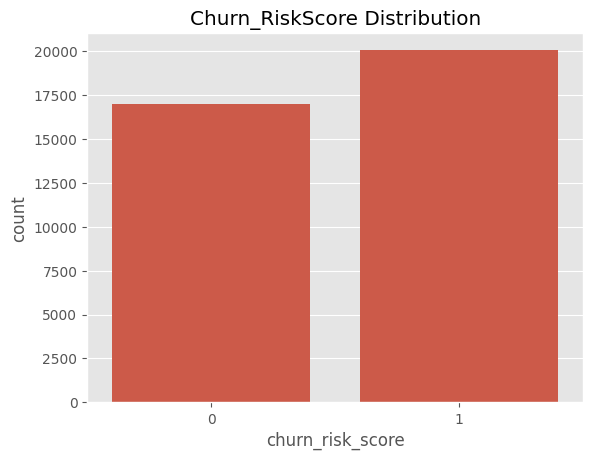

<Figure size 1200x800 with 0 Axes>

In [20]:
sns.countplot(x='churn_risk_score', data=df, orient = 'h')

plt.title('Churn_RiskScore Distribution')
plt.figure(figsize=(12, 8))

Text(0.5, 1.0, 'Churn % by Region')

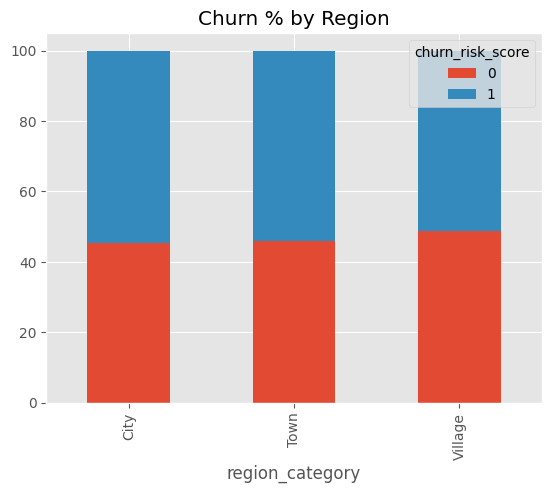

In [21]:
cross_tab = pd.crosstab(df['region_category'], df['churn_risk_score'], normalize='index') * 100
cross_tab.plot(kind='bar', stacked=True)
plt.title('Churn % by Region')

<Axes: title={'center': 'Churn Rate by Region'}, xlabel='region_category'>

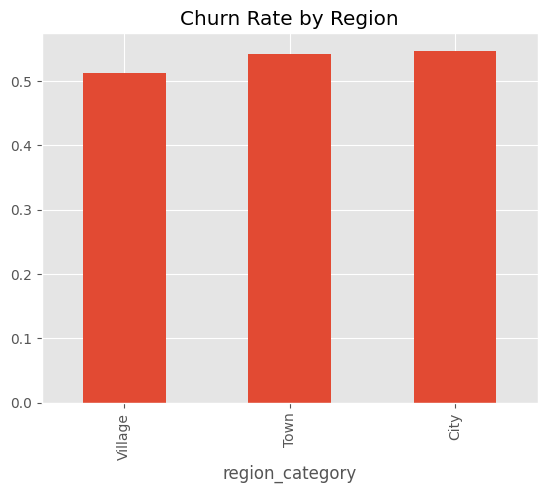

In [23]:
churn_rate_by_region = df.groupby('region_category')['churn_risk_score'].mean().sort_values()
churn_rate_by_region.plot(kind='bar', title='Churn Rate by Region')